<a href="https://colab.research.google.com/github/Dreadnought73/AI_projects/blob/main/Bankrupcy_predictor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Coding_data_files/Bankcrupcy_rate.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


This is to check the number of rows and columns.

In [ ]:
df.shape

(6819, 96)

Checking for possible imbalances in my target value. As we can see, there is actually quite a huge one!

In [ ]:
df['Bankrupt?'].value_counts()

,count
Bankrupt?,
0,6599
1,220


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Looking for null values, but found none.

In [ ]:
df.isnull().sum()

,0
Bankrupt?,0
ROA(C) before interest and depreciation before interest,0
ROA(A) before interest and % after tax,0
ROA(B) before interest and depreciation after tax,0
Operating Gross Margin,0
...,...
Liability to Equity,0
Degree of Financial Leverage (DFL),0
Interest Coverage Ratio (Interest expense to EBIT),0
Net Income Flag,0


Checking for initial correlations based on statistical inference.

In [ ]:
correlations = df.corr()['Bankrupt?'].abs().sort_values(ascending=False)
correlations.head(8)

,Bankrupt?
Bankrupt?,1.000000
Net Income to Total Assets,0.315457
ROA(A) before interest and % after tax,0.282941
ROA(B) before interest and depreciation after tax,0.273051
ROA(C) before interest and depreciation before interest,0.260807
Net worth/Assets,0.250161
Debt ratio %,0.250161
Persistent EPS in the Last Four Seasons,0.219560


Separating the feature columns from the target column. Then, splitting the data into sets.

In [ ]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Trying to find out which classification model would work the best for this based on the accuracy data.

Side note: better to try out other evaluation metrics, since the class is imbalanced

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
def find_best_model(models, X_train, y_train, X_test, y_test):
  '''
  Considering 3 as possible options:
  Logistic regression, KNN, Random Forest classifier
  '''
  accuracy_point = {}
  precision_point = {}
  recall_point = {}
  f1_point = {}

  for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_point[model] = accuracy
    precision_point[model] = precision
    recall_point[model] = recall
    f1_point[model] = f1

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

  return table


model = {
    'lr':LogisticRegression(max_iter=300),
    'KNN':KNeighborsClassifier(n_neighbors=5),
    'rf':RandomForestClassifier(n_estimators=50)
}

best_classifier = find_best_model(model, X_train, y_train, X_test, y_test)
print(best_classifier)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  model  precision    recall        F1  accuracy
0    rf        0.7  0.137255  0.229508  0.965543


The accuracy is pretty high, however, due to low recall rate, it might be suspected that the model learns to always go for '0' and then it gets it right most of the time.

Since the Random Frest Classifier had the best accuracy, I went with that. Then based on feature importance, I sorted the features to see which are the ones correlated the most.

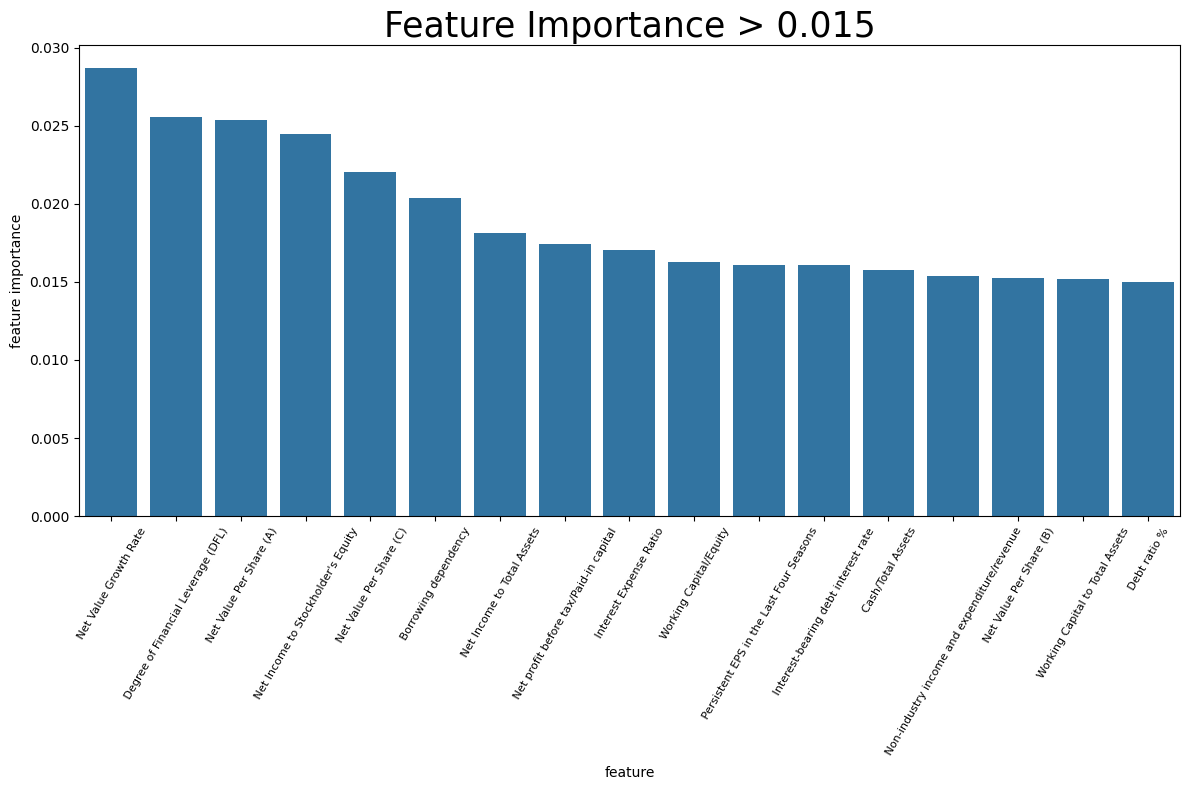

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

sorted_idx = (-rf.feature_importances_).argsort()

list_of_tuples = list(zip(X.columns[sorted_idx],
                          rf.feature_importances_[sorted_idx]))

feat_importance = pd.DataFrame(list_of_tuples,
                  columns=['feature', 'feature importance'])


fig = plt.figure(figsize=(12,8))

fig = sns.barplot(data=feat_importance[feat_importance['feature importance'] > 0.015], x='feature', y='feature importance')
plt.title('Feature Importance > 0.015',fontsize=25)
plt.xticks(fontsize=8,rotation=60)

plt.tight_layout()

Based on feature importance, I separated the features that had above 0.01 and 0.02 correlation

In [ ]:
col_1 = feat_importance[feat_importance['feature importance'] > 0.01]['feature'].tolist()
col_2 = feat_importance[feat_importance['feature importance'] > 0.02]['feature'].tolist()

X[col_2].head()

,Net Value Growth Rate,Degree of Financial Leverage (DFL),Net Value Per Share (A),Net Income to Stockholder's Equity,Net Value Per Share (C),Borrowing dependency
0,0.000327,0.026601,0.147950,0.827890,0.147950,0.390284
1,0.000443,0.264577,0.182251,0.839969,0.182251,0.376760
2,0.000396,0.026555,0.177911,0.836774,0.193713,0.379093
3,0.000382,0.026697,0.154187,0.834697,0.154187,0.379743
4,0.000439,0.024752,0.167502,0.839973,0.167502,0.375025


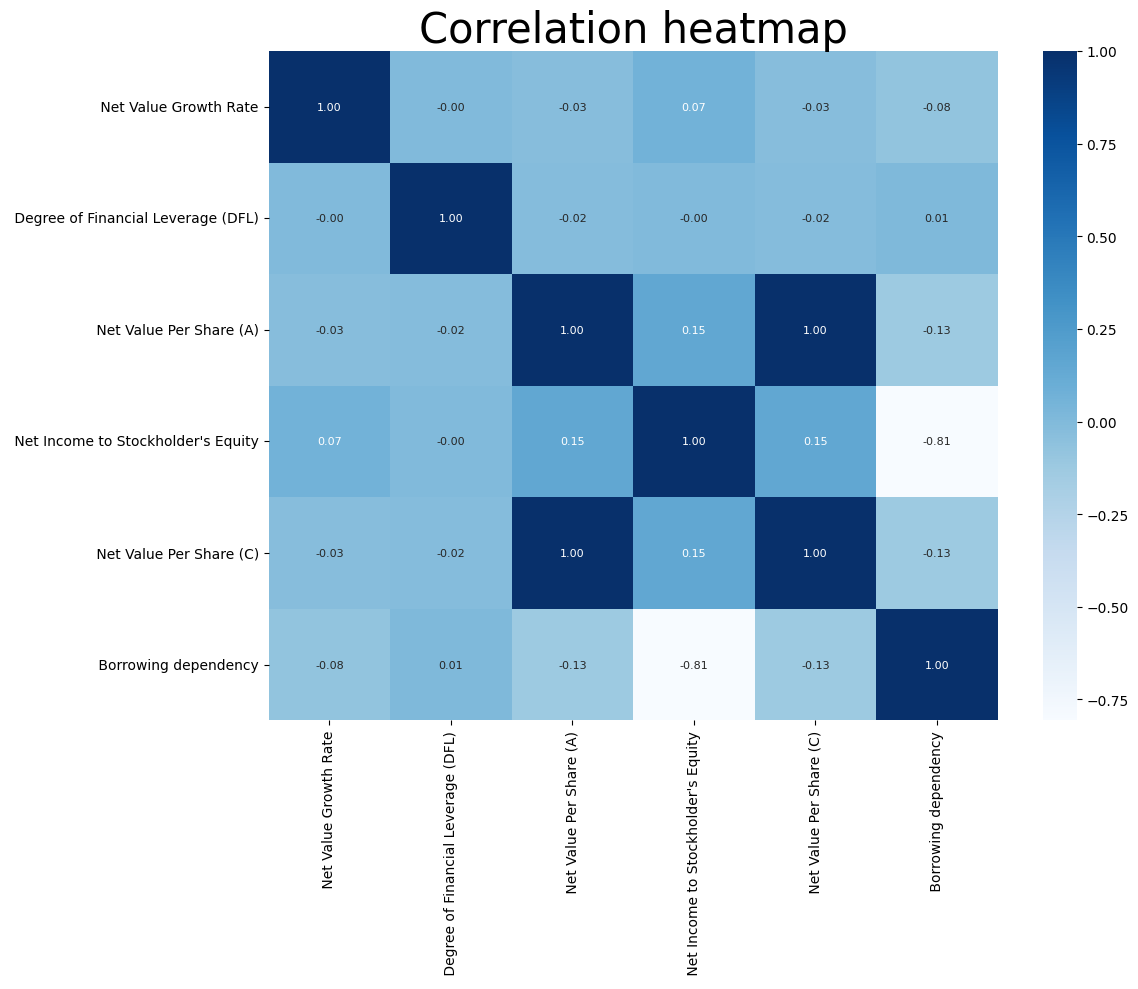

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(X[col_2].corr(method='pearson'),annot=True,fmt='.2f',annot_kws={"fontsize":8},cmap='Blues')
plt.title('Correlation heatmap',fontsize=30)

plt.tight_layout()
plt.show()

Since the class was imbalanced, this served as the first way to solve the problem by oversampling (duplicating the minority class)

Class distribution after oversampling:
Bankrupt?
0    6599
1    6599
Name: count, dtype: int64


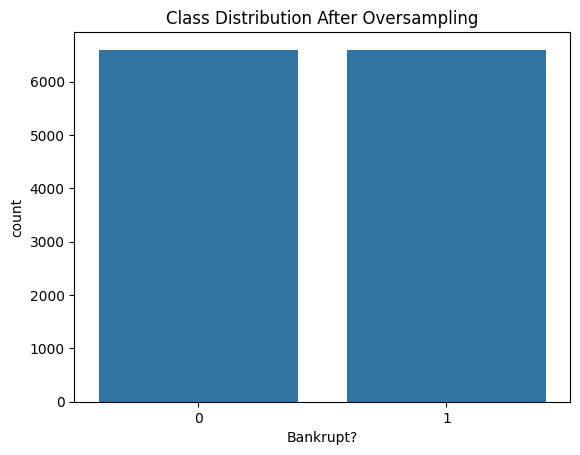

In [ ]:
from sklearn.utils import resample

df_oversampling = df.copy()

# Separate majority and minority classes
df_majority = df_oversampling[df_oversampling['Bankrupt?'] == 0]
df_minority = df_oversampling[df_oversampling['Bankrupt?'] == 1]

n_samples_oversample = len(df_majority)

# Oversample the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,     # sample with replacement
                                   n_samples=n_samples_oversample,
                                   random_state=42) # for reproducibility

df_oversampled = pd.concat([df_majority, df_minority_oversampled])


print("Class distribution after oversampling:")
print(df_oversampled['Bankrupt?'].value_counts())
sns.countplot(x='Bankrupt?', data=df_oversampled)
plt.title('Class Distribution After Oversampling')
plt.show()

Creating new X and y with the resampled features, then splitting into sets.

In [ ]:
X_oversampled = df_oversampled.drop('Bankrupt?', axis=1)
y_oversampled = df_oversampled['Bankrupt?']
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_oversampled, y_oversampled, test_size=.2, random_state=42)

Initiated another Random Forest Classifier and checked its accuracy. But later turned out to be misleading again. (Though the accuracy got better)

In [ ]:
rf_sampled = RandomForestClassifier(n_estimators=50)
rf_sampled.fit(X_train_sampled, y_train_sampled)
y_pred_sampled = rf_sampled.predict(X_test_sampled)

print('Accuracy of training data ', rf_sampled.score(X_train_sampled, y_train_sampled))
print('Accuracy of test data ', rf_sampled.score(X_test_sampled, y_test_sampled))

Accuracy of training data  1.0
Accuracy of test data  0.9943181818181818


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, confusion_matrix

print(precision_score(y_test_sampled, y_pred_sampled))

print(recall_score(y_test_sampled, y_pred_sampled))

print(f1_score(y_test_sampled, y_pred_sampled))

print("Confusion Matrix:")
print(confusion_matrix(y_test_sampled, y_pred_sampled))

0.9886963074604371
1.0
0.9943160287987874
Confusion Matrix:
[[1313   15]
 [   0 1312]]


The model received a surprisingly good score on all factors, it might be because the values were duplicated and it memorised them when one of them came again.

Initiating a new function to get the evaluation metrics more easily in the next steps that are aimed to find different ways to produce a model.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


def get_test_scores(model_name:str,preds,y_test_data):

    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table

Doing another oversampling method, SMOTE, to avoid exact duplication.


Class distribution in training set after SMOTE:
Bankrupt?
0    5286
1    5286
Name: count, dtype: int64


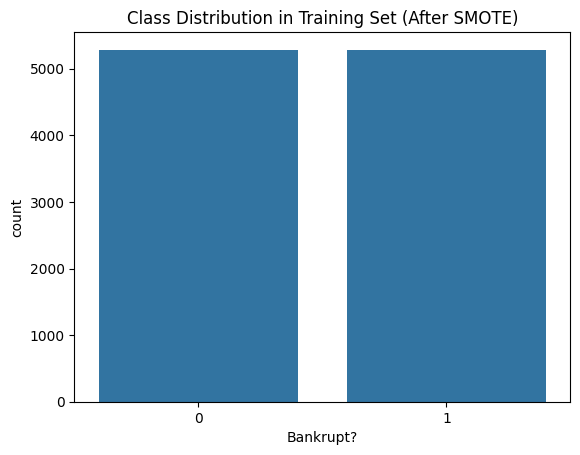

In [ ]:
from imblearn.over_sampling import SMOTE

df_smote = df.copy()
# Separate majority and minority classes
df_majority = df_smote[df_smote['Bankrupt?'] == 0]
df_minority = df_smote[df_smote['Bankrupt?'] == 1]

X_smote = df_smote.drop('Bankrupt?', axis=1)
y_smote = df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=.2, random_state=42)

# Oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution in training set after SMOTE:")
print(y_train_smote.value_counts())
sns.countplot(x=y_train_smote)
plt.title('Class Distribution in Training Set (After SMOTE)')
plt.show()

Tried to see if variance threshold feature selection could yield any better results.

In [ ]:
variance_selector = VarianceThreshold(threshold=.15)

X_selected = variance_selector.fit(X_smote)
key_selectors = variance_selector.get_support()
key_selectors_name = X_smote.columns[key_selectors]

print(key_selectors) # False: should be kept, True: should be discarded
print(key_selectors_name)
print(len(key_selectors_name))

[False False False False False False False False False False  True  True
 False  True False False False False False False  True False False False
 False False False False  True  True False False  True  True False  True
 False False False False False False False False False  True  True  True
  True False  True False  True False False False False  True  True False
 False False  True False False False  True False False False  True  True
 False  True False  True False False False False False False False False
 False False  True False False False False False False False False]
Index([' Operating Expense Rate', ' Research and development expense rate',
       ' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan ¥)',
       ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Current Ratio',
       ' Quick Ratio', ' Total debt/Total net worth',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover

Tried to see if Sequential Feature Selection was a good way.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500, random_state=42)

forward_selector = SequentialFeatureSelector(lr,
                                             n_features_to_select=18, # number of features to remove
                                             direction='forward', # specifies the direction of going through the features
                                             cv=4)  # Number of cross-validation folds
forward_selector.fit(X_train, y_train)
forward_selected_features = X_train.columns[forward_selector.get_support()].tolist()
X_train_forward = forward_selector.transform(X_train)
# X_test_forward = forward_selector.transform(X_test)

print("Forward Selected Features:", forward_selected_features)
print("Shape of X_train (forward):", X_train_forward.shape)
# print("Shape of X_test (forward):", X_test_forward.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/skle

Forward Selected Features: [' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Cash flow rate', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Realized Sales Gross Profit Growth Rate', ' Working Capital to Total Assets', ' Cash Flow to Total Assets', " Net Income to Stockholder's Equity"]
Shape of X_train (forward): (5455, 18)


Separating the features that were selected by the two feature selection methods.

In [ ]:
selected_by_variance = X_smote[key_selectors_name]
selected_by_sequential = X_smote[forward_selected_features]

In [ ]:
X_train_variance, X_test_varianca, y_train_variance, y_test_variance = train_test_split(selected_by_variance, y_smote, test_size=.2, random_state=42)

lr.fit(X_train_variance, y_train_variance)
y_pred_variance = lr.predict(X_test_varianca)

get_test_scores('Logistic Regression after VarianceThreshold', y_pred_variance, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,precision,recall,F1,accuracy
0,Logistic Regression after VarianceThreshold,0.481278,0.499238,0.490093,0.961144


Now, we definitiely have better recall with VarianceThreshold, so that might be a good sign.

In [ ]:
X_train_sequential, X_test_sequential, y_train_sequential, y_test_sequential = train_test_split(selected_by_sequential, y_smote, test_size=.2, random_state=42)

lr.fit(X_train_sequential, y_train_sequential)
X_test_forward = lr.predict(X_test_sequential)

Here, I was trying to find a good threshold for the logistic regression model so that the recall, predicting liquid companies as unliquid too, is higher. Then found .04 as a relatively good, but it decreases too much the precision!


--- Threshold: 0.1 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1313
           1       0.42      0.35      0.38        51

    accuracy                           0.96      1364
   macro avg       0.70      0.67      0.68      1364
weighted avg       0.95      0.96      0.96      1364

Confusion Matrix:
[[1288   25]
 [  33   18]]

--- Threshold: 0.09 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1313
           1       0.38      0.41      0.40        51

    accuracy                           0.95      1364
   macro avg       0.68      0.69      0.69      1364
weighted avg       0.95      0.95      0.95      1364

Confusion Matrix:
[[1279   34]
 [  30   21]]

--- Threshold: 0.08 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
    

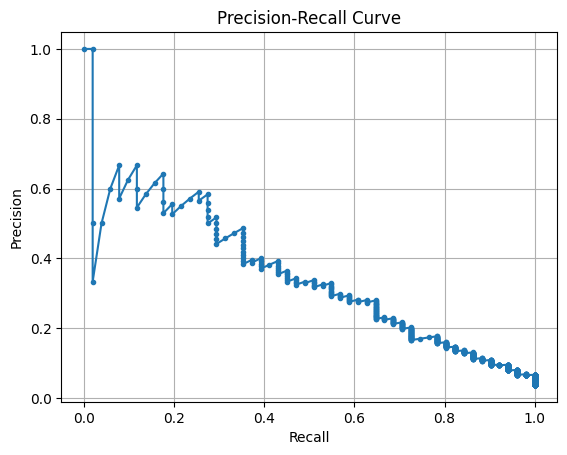

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix

y_pred_proba = lr.predict_proba(X_test_sequential)[:, 1]
thresholds = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05]

for threshold in thresholds:
    print(f"\n--- Threshold: {threshold} ---")
    y_pred_threshold = (y_pred_proba > threshold).astype(int)
    print("Classification Report:")
    print(classification_report(y_test_sequential, y_pred_threshold))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_sequential, y_pred_threshold))

# Visualizing the Precision-Recall Curve to help choose a threshold
precision, recall, thresholds_pr = precision_recall_curve(y_test_sequential, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

Checking the confusion matrix for threshold=.04

In [ ]:
print('prediction with threshold 0.04 :')
y_pred_new_threshold = (lr.predict_proba(X_test_sequential)[:, 1] >= 0.04).astype(int)
print(y_pred_new_threshold)

print("Confusion Matrix:")
print(confusion_matrix(y_test_sequential, y_pred_new_threshold))

prediction with threshold 0.04 :
[1 0 0 ... 0 0 0]
Confusion Matrix:
[[1113  200]
 [  11   40]]


Evalutating the model for threshold=.04

In [ ]:
print("Evaluation metrics with threshold 0.04:")
print("Accuracy:", accuracy_score(y_test_sequential, y_pred_new_threshold))
print("Precision:", precision_score(y_test_sequential, y_pred_new_threshold))
print("Recall:", recall_score(y_test_sequential, y_pred_new_threshold))
print("F1 score:", f1_score(y_test_sequential, y_pred_new_threshold))

Evaluation metrics with threshold 0.04:
Accuracy: 0.8453079178885631
Precision: 0.16666666666666666
Recall: 0.7843137254901961
F1 score: 0.27491408934707906


Now, with this threshold the model can more accurately predict correctly unliquid companies, but it is terrible at predicting liquid that are actually liquid.

Outlining the ROC curve to see how the elements of the confusion matrix changed throughout the model

Area Under the ROC Curve for threshold 0.4: 0.9009154309096068
Area Under the ROC Curve for threshold 0.04: 0.8159954004450218


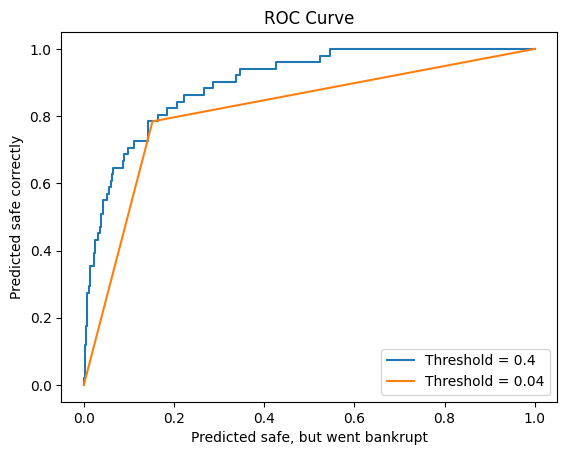

In [ ]:
y_scores = lr.predict_proba(X_test_sequential)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_sequential, y_scores)
plt.plot(fpr, tpr,  label = 'Threshold = 0.4')
print('Area Under the ROC Curve for threshold 0.4:', roc_auc_score(y_test_sequential, y_scores))

fpr_, tpr_, thresholds_ = roc_curve(y_test_sequential, y_pred_new_threshold)
print('Area Under the ROC Curve for threshold 0.04:', roc_auc_score(y_test_sequential, y_pred_new_threshold))
plt.plot(fpr_, tpr_, label = 'Threshold = 0.04')

plt.xlabel('Predicted safe, but went bankrupt')
plt.ylabel('Predicted safe correctly')
plt.title('ROC Curve')
plt.legend()
plt.show()